<a href="https://colab.research.google.com/github/RomandRapido/Mutation-Simulation/blob/main/(1)_ProbabilityDensityEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("gridExtra")
install.packages("viridis")

library(ggplot2)
library(gridExtra)
library(MASS)
library(viridis)
library(tidyverse)
library(dplyr)
library(readr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: viridisLite

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ stringr   1.5.1
✔ forcats   1.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Probability Density Estimation

Before proceeding to any rigorous statistical analysis, it is always smart to start with Exploratory Data Analysis. An exploratory data analysis, particularly the employment of Probability Density Estimation, will be done in order to visualize the underlying variables, `Temperature` (T) and Mutation-Induced Stability Changes `ΔΔG` (DDG). This is all done to reveal the shape, central tendency, skewness, and estimate the relationship between the earlier mentioned variables.

The primary strategy to accomplish the purpose of this section is to segment the `Temperature` and see if there's a difference in the distribution of the  `ΔΔG` given their segment.

In [ ]:
download_url <- "https://drive.google.com/uc?export=download&id=1tU6BBBjPZ1FoGuQzmlttWxyk3w_uGq53"
df <- read_csv(download_url)

cat(nrow(df), "X", ncol(df))
head(df)

Rows: 2648 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): CLID, PDB, CHAIN, MUT
dbl (3): DDG, pH, T

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


2648 X 7

CLID,PDB,CHAIN,MUT,DDG,pH,T
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1A23A,1FVK,A,C30S,-1.79,7.5,25
1A23A,1FVK,A,C33S,-1.15,7.5,25
1A23A,1FVK,A,H32L,5.30,7.0,30
1A23A,1FVK,A,H32S,5.20,7.0,30
1A23A,1FVK,A,H32Y,6.80,7.0,30
1A43A,1A43,A,C218S,-3.70,7.3,25


## Temperature Distribution

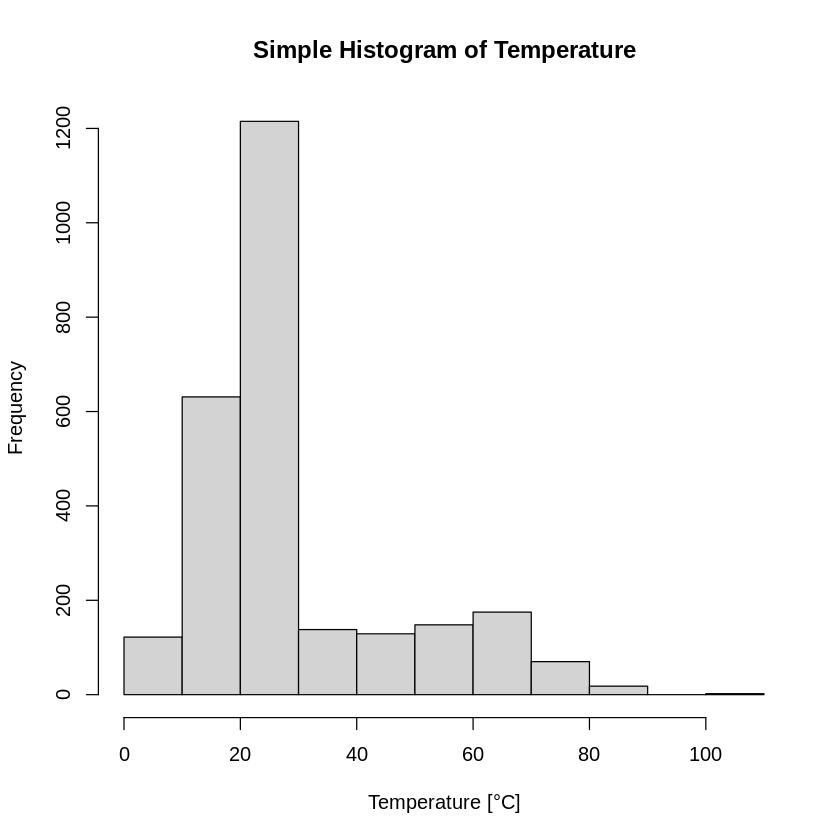

In [ ]:
temp <- df$T
hist(temp, main="Simple Histogram of Temperature", xlab = "Temperature [°C]")

Based on the simple histogram above, its clear that the distribution of Temperature variable have is heavily concentrated around 20-30°C with flattened distribution beyond that point. Without proper binning, it's difficult to be precise with the distribution.  

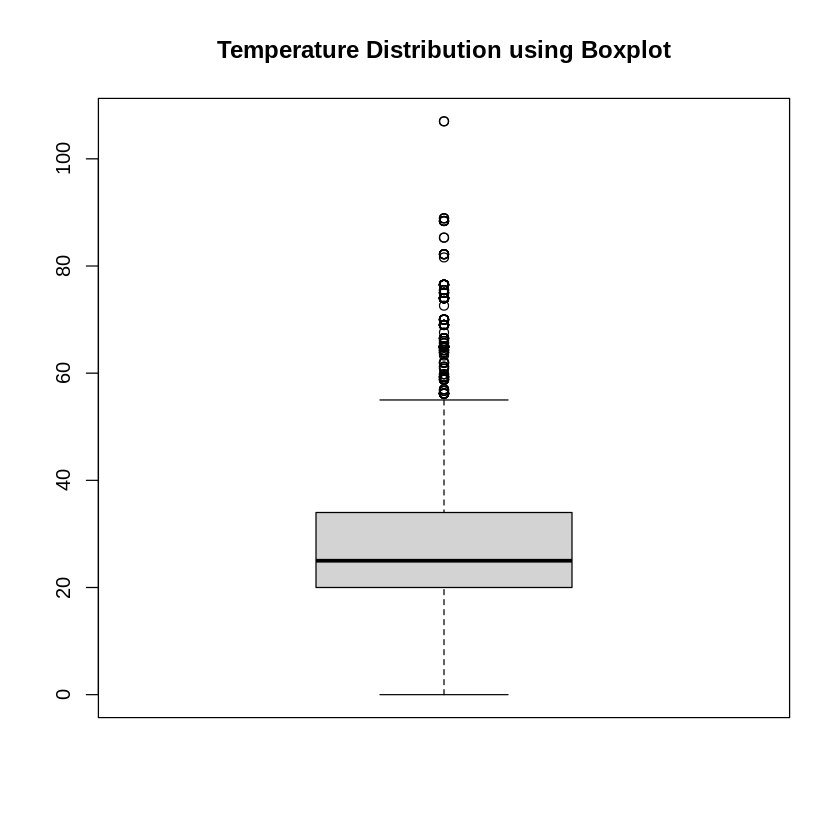

In [ ]:
boxplot(df$T, main="Temperature Distribution using Boxplot")

The boxplot of `Temperature` graphically show that there were plenty of outliers. Consequently, Sturges' rule (since it assumes normality and relies on mean and std) for binning would not be best. Instead it is better to resort to Freedman-Diaconis rule. This particular rule uses Range as a central tendency and IQR as dispersion, making it robust to outliers.

In [ ]:
plot_hist <- function(df, col, bins, bw, xlab, title, func=NULL, args=NULL, theo_title=NULL){
  histo <- ggplot(df, aes(x = !!sym(col))) +
  geom_histogram(aes(y = after_stat(density), fill = "Histogram"),
                 bins = bins, color = "black", alpha = 0.7) +
  geom_density(aes(color = "KDE"), bw = bw, linewidth = 1) +
  labs(title = title,
       x = xlab, y = "Density") +
  theme_minimal() +
  annotate("text", x = max(df[[col]]) * 0.7, y = max(density(df[[col]])$y) * 0.9,
           label = paste("N =", length(df[[col]]), "\nBandwidth =", bw)) +
  scale_x_continuous(breaks = seq(from = floor(min(df[[col]])),
                                  to = ceiling(max(df[[col]])),
                                  by = 5)) +
  scale_fill_manual(name = "", values = c("Histogram" = "lightblue")) +
  theme(legend.position = "top")

   if (!is.null(func)) {
    histo <- histo +
      stat_function(fun = func, args = args, aes(color = !!theo_title),
                    linewidth = 1.2, linetype = "dashed") +
      scale_color_manual(
        name = "",
        values = c("KDE" = "red", setNames("purple", theo_title)),
        labels = c("KDE" = "Kernel Density Estimate", setNames(theo_title, theo_title))
      ) +
      guides(color = guide_legend(
        override.aes = list(
          linetype = c("solid", "dashed"),
          linewidth = c(1, 1.2)
        )
      ))
  } else {
    histo <- histo +
      scale_color_manual(name = "",
                         values = c("KDE" = "red"),
                         labels = c("KDE" = "Kernel Density Estimate"))
  }

  return(histo)
}

In [ ]:
fd_rule <- function(X){
  bins <- ceiling((max(X) - min(X)) / (2 * IQR(X) / (length(X)^(1/3))))
}

n_fd_T <- fd_rule(df$T)
cat("Optimal Number of Bins By Freedman-Diaconis Rule", n_fd_T)

Optimal Number of Bins By Freedman-Diaconis Rule 53

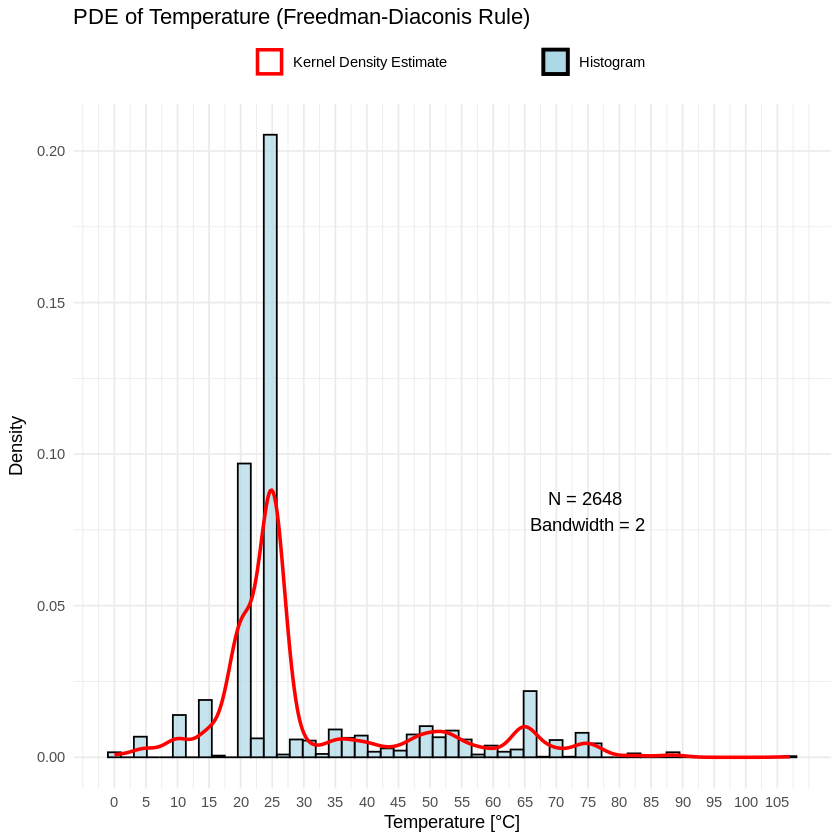

In [ ]:
plot_hist(df,
          "T",
          n_fd_T,
          bw=2,
          xlab= "Temperature [°C]",
          title="PDE of Temperature (Freedman-Diaconis Rule)")

Now with a proper binning technique, the distribution became more apparent. Outliers and skewness is still present but what stood out in this graph is the `Temperature` being multimodal. This is important for the initial strategy of segmenting the `Temperature` and compare their distribution.

There appear to be 4 modes of temperature, the "Low" being all temperature at 31°C and below. Then a small valley, say "Medium", upto 42°C. Then "High" upto 60°C. Finally, 60°C above with "Very High." Although it's wise to group the "Low" and "Medium" together since the mode isn't that significant to begin with in the "Medium" part. As an added bonus, the final visualization of segmented distribution will not be cluttered and therefore will be easier to analyze.

In [ ]:
df$temp_group <- cut(df$T, breaks = c(-Inf, 42, 60, Inf),
                     labels = c("Low/Medium (<=42°C)",
                               "High (42°C < T <= 60°C)",
                               "Very High (>60°C)"))

In [ ]:
df %>%
  group_by(temp_group) %>%
  summarize(count = length(T),mean = mean(T), median = median(T))

temp_group,count,mean,median
<fct>,<int>,<dbl>,<dbl>
Low/Medium (<=42°C),2116,23.14532,25.0
High (42°C < T <= 60°C),267,51.22734,51.8
Very High (>60°C),265,69.73132,66.5


## Mutation-Induced Stability Changes (ΔΔG) Distribution


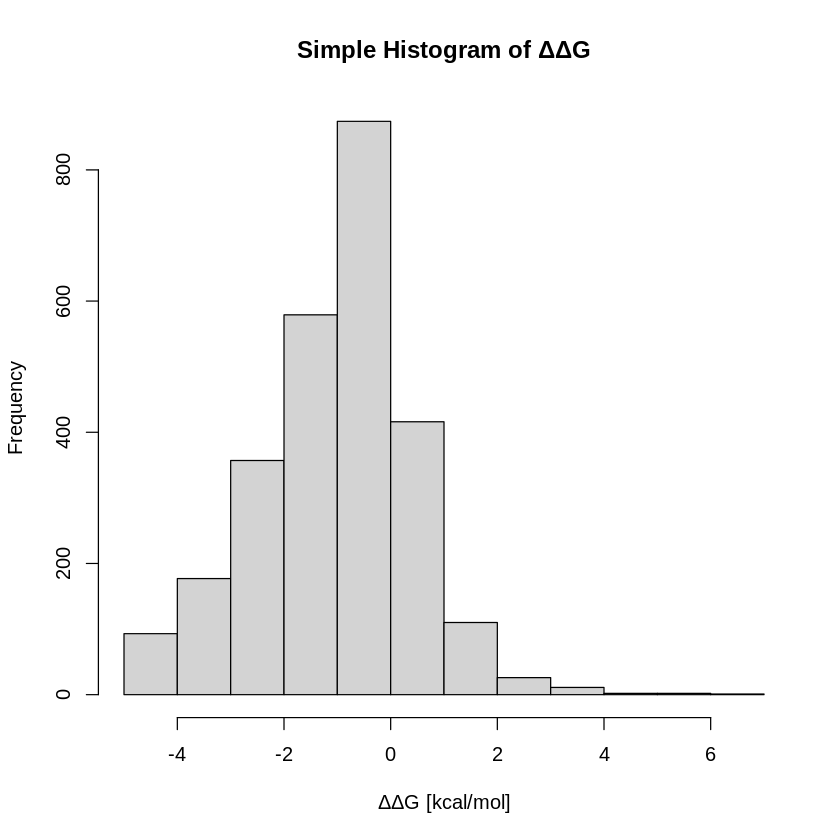

In [ ]:
ddg <- df$DDG
hist(ddg, main="Simple Histogram of ΔΔG", xlab = "ΔΔG [kcal/mol]")

This distribution of Mutation-Induced Stability Changes using simple histogram looks more normally distributed than that of `Temperature` earlier. Although, it still is rightly-skewed with some probable outliers present.

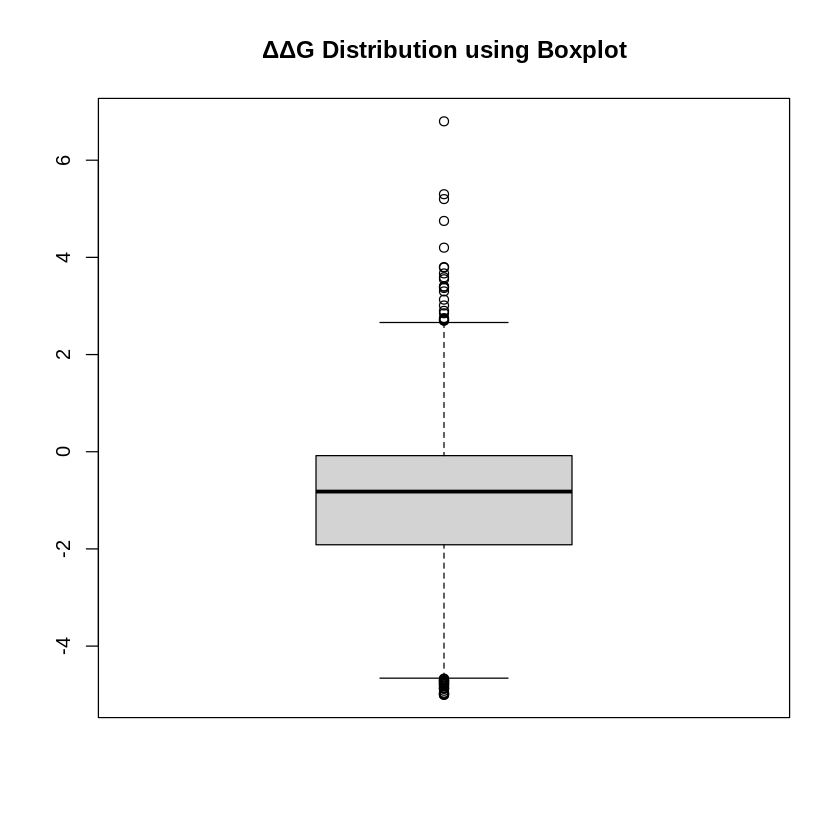

In [ ]:
boxplot(df$DDG, main="ΔΔG Distribution using Boxplot")

From the Boxplot, it's apparent that outliers are present on the lower and the higher end. Although it seems that extreme values happened more frequently (more variance too) in the higher end. This is a crucial finding. It means that while large stabilizing effects (ΔΔG < -4) are relatively rare, large destabilizing effects (e.g., ΔΔG > +2) are more common. This aligns perfectly with biological intuition: a random change to a highly evolved system like a protein is more likely to break it (destabilize it) than to improve it (stabilize it).

In [ ]:
n_fd_ddg <- fd_rule(df$DDG)
cat("Optimal Number of Bins By Freedman-Diaconis Rule", n_fd_ddg)

Optimal Number of Bins By Freedman-Diaconis Rule 45

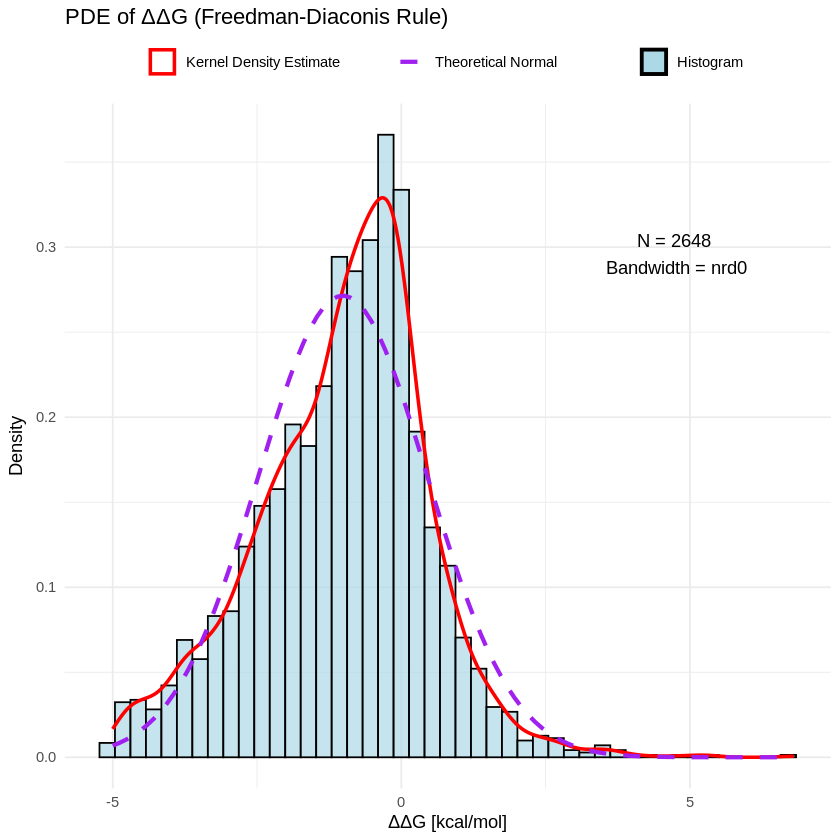

In [ ]:
plot_hist(df,
          "DDG",
          n_fd_ddg,
          bw="nrd0",
          xlab= "ΔΔG [kcal/mol]",
          title="PDE of ΔΔG (Freedman-Diaconis Rule)",
          func = dnorm,
          args = list(mean = mean(df$DDG), sd = sd(df$DDG)),
          theo_title = "Theoretical Normal")

This just confirms the earlier insight that the distribution ΔΔG is an approximately normal distribution that's slighly rightly skewed.

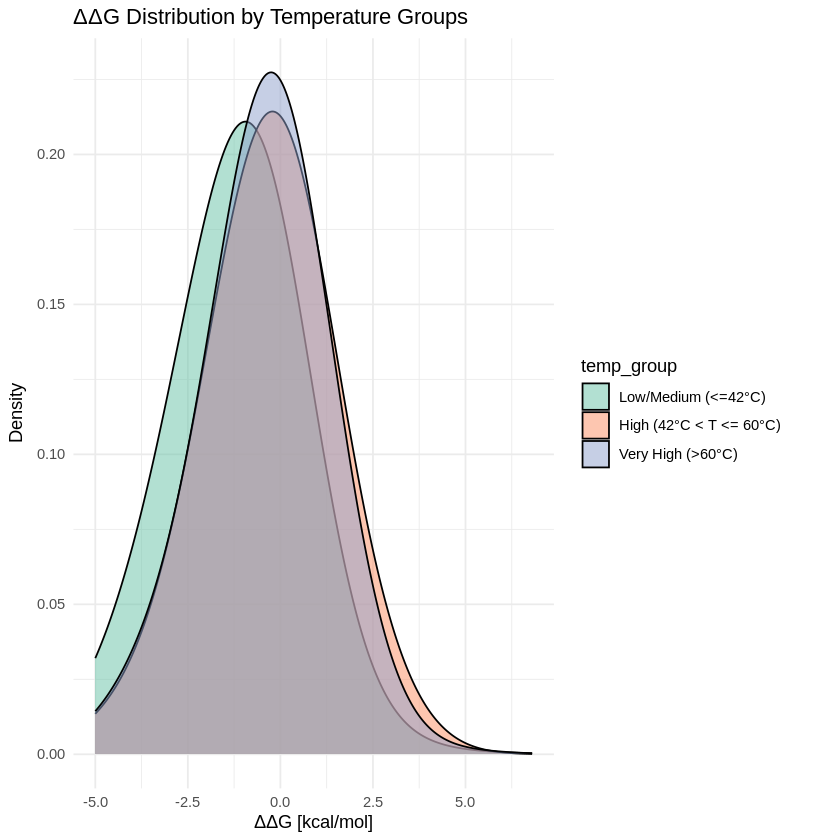

In [ ]:
ggplot(df, aes(x = DDG, fill = temp_group)) +
  geom_density(alpha = 0.5, bw=1.3) +
  labs(title = "ΔΔG Distribution by Temperature Groups",
       x = "ΔΔG [kcal/mol]", y = "Density") +
  theme_minimal() +
  scale_fill_brewer(palette = "Set2")


From the **ΔΔG Distribution by Temperature Groups**, the difference between Temperature Groups becomes clearer.
- **Region Difference** - The most significant finding is the clear rightward shift of the distributions with increasing temperature. The Low/Medium curve's peak is clearly in the negative (stabilizing) region. The High (orange) and Very High (purple) curves are both shifted significantly to the right. Their peaks are much closer to zero. This implies the general trend that when temperature rises, a mutation shifts from being stabilizing to being nearly neutral or slightly destabilizing.

- **Higher Temperature groups have more concentration** - This too is an the obvious difference between the groups. The Low/Medium group appear to have lower peak and more spread out compared to the other two. The Very High group, on the other hand, is highly concentrated around the center. This suggests that at very high temperatures, the range of mutational effects becomes somewhat narrower.

In [ ]:
df %>%
  group_by(temp_group) %>%
  summarize(count = length(DDG),mean = mean(DDG), median = median(DDG), std= sd(DDG), min=min(DDG),max=max(DDG))

temp_group,count,mean,median,std,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low/Medium (<=42°C),2116,-1.1699480,-0.995,1.452092,-5.00,6.80
High (42°C < T <= 60°C),267,-0.3373408,-0.130,1.416700,-4.60,3.40
Very High (>60°C),265,-0.4441509,-0.290,1.324762,-4.96,4.75


These aggregated not only supported the earlier insights but also presents a more nuanced understanding on the relationship between the temperature groups.
- **Lower Variance with Higher Temperatures**- this goes without saying given the visualization earlier showed the highly concentrated distribution of higher temperature groups (especially the Very High).
- **Shift in Central Tendency** -  with a median ΔΔG of -0.995 kcal/mol, the Low/Medium Temperature is confirmed to be well within the stabilizing region compared to Higher Temperature Groups that are more centered around zero.
- **Non-Linear Relationship** - while the general trend implies a shift toward destabilization, the relationship is not perfectly linear. The largest destabilizing effect is seen in the High group. The Very High group shows a slight reversal, becoming slightly less destabilizing than the 'High' group. This complex behavior is critical, suggesting that a simple linear model may not fully capture the relationship.
- **selection bias** - Another probable cause for this non-linear behaviour may lie on selection bias since the proteins studied at very high temperatures were likely not chosen randomly or they were SPECIFICALLY selected because they could survive those conditions in the first place! A researcher that wants to study the effect of a mutation at, say 75°C, cannot just pick any random protein since most "normal" protein will turn into glob very quickly.

## Conclusion
Our exploratory analysis using Probability Density Estimation has successfully uncovered the core (and some nuance) dynamics in the dataset. It was shown that the rising temperatures can fundamentally alter the impact of mutations, making it more neutral from stabilized state. This analysis also shown a probable non-linear trend that may serve as a foundational insight to a more rigorous statistical analysis and hypothesis testing.